## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
##  Using chessboard images to extract object points and image points for camera calibration.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib
#matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

#plt.switch_backend('Qt5Agg')
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calculate distortion coefficients, and test undistortion on an image.

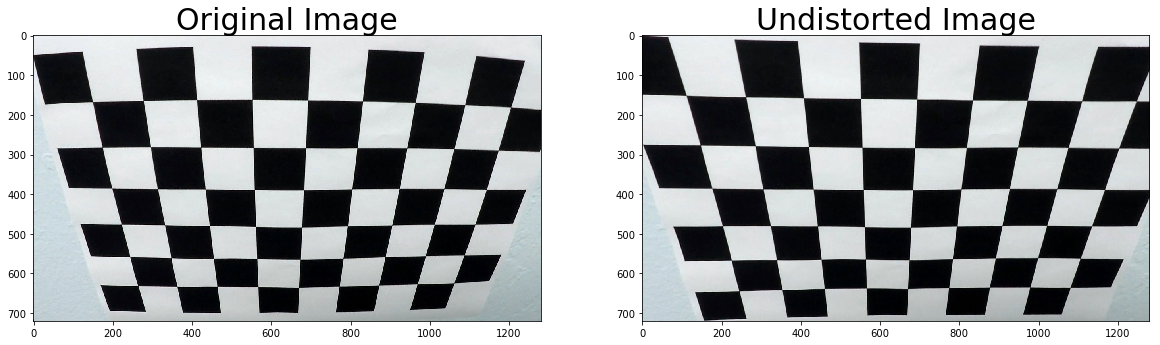

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
# dist: distortion coefficients
# mtx: The camera matrix that we need to transform 3D object points to 2D object points.
# rvecs. tvecs: It also return the positions of the camera in the world, with values of rotaion vectos and translation vectors.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration2_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_coefficient.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Undistort a raw image

Text(0.5,1,'Undistorted Image')

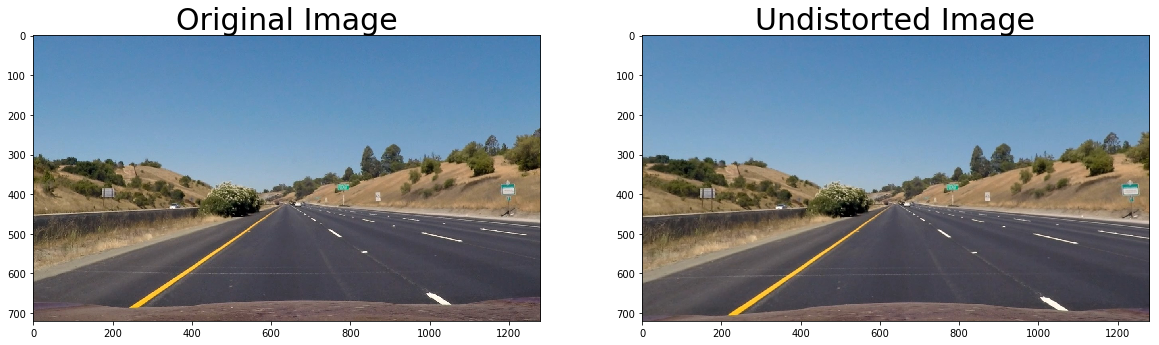

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline

with open('dist_coefficient.p', mode='rb') as f:
    dist_coefficient = pickle.load(f)

mtx = dist_coefficient["mtx"] 
dist = dist_coefficient["dist"]

img = plt.imread("test_images/straight_lines1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/straight_lines1_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

 # Thresholded binary images

 ## Playground

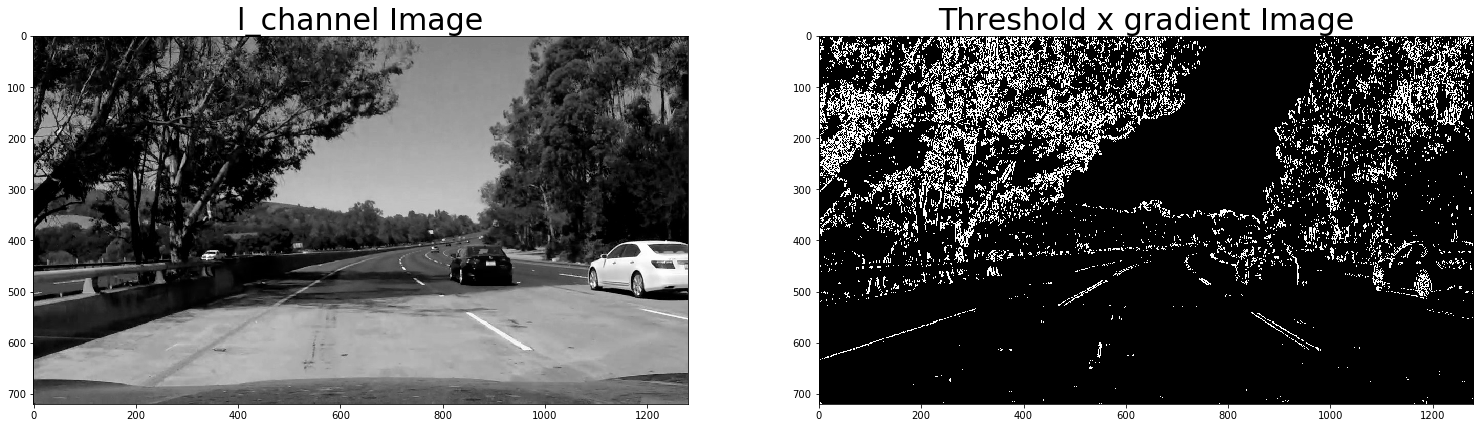

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline
image = mpimg.imread('test_images/test5.jpg')
img = np.copy(image)
sx_thresh=(20, 100)
# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
# Sobel x
sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(l_channel, cmap="gray")
ax1.set_title('l_channel Image', fontsize=30)
ax2.imshow(sxbinary, cmap="gray")
ax2.set_title('Threshold x gradient Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

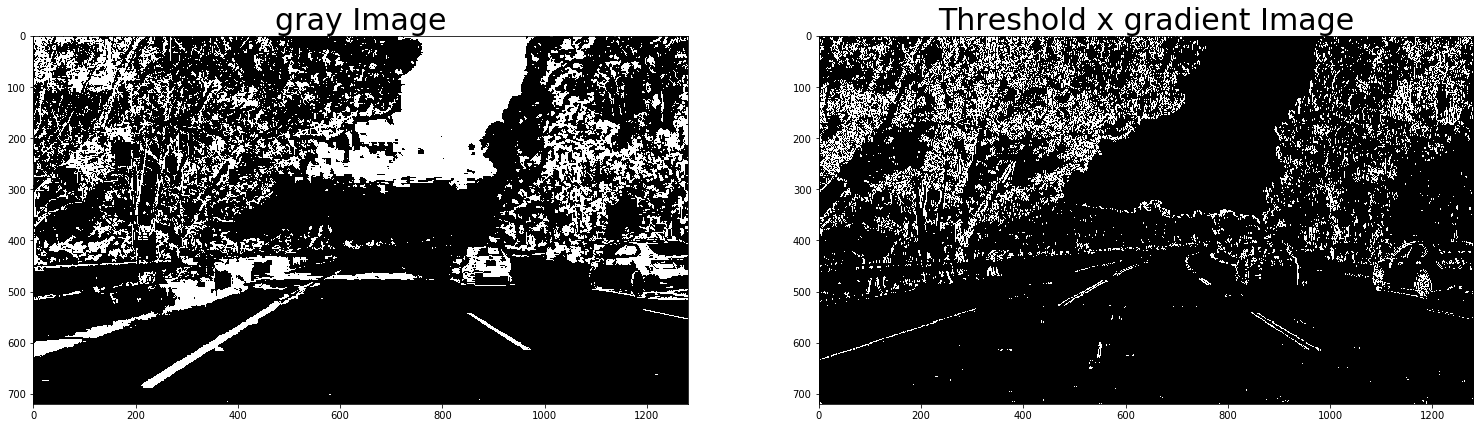

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline
image = mpimg.imread('test_images/test5.jpg')
img = np.copy(image)
sx_thresh=(20, 100)
# Convert to HLS color space and separate the V channel
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

def l_channel_thres(img, sobel_kernel=3, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,2]
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    return l_binary

l_binary = l_channel_thres(img, 9, thresh=(100, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(l_binary, cmap="gray")
ax1.set_title('gray Image', fontsize=30)
ax2.imshow(sxbinary, cmap="gray")
ax2.set_title('Threshold x gradient Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

 ## Thresholded binary methods

In [2]:
def abs_sobel_thresh(rgb_img, orient='x', sobel_kernel=3,thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(rgb_img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(rgb_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def s_channel_thres(rgb_img, sobel_kernel=3, thresh=(0, 255)):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def l_channel_thres(rgb_img, sobel_kernel=3, thresh=(0, 255)):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    return l_binary

def combined_thres(rgb_img):
    ksize = 9
    sxbinary = abs_sobel_thresh(rgb_img, 'x', ksize, (20, 100))
    sbinary = s_channel_thres(rgb_img, ksize, (170, 255))
    l_binary = l_channel_thres(rgb_img, ksize, thresh=(100, 255))
    combined = np.zeros_like(sxbinary)
    
    combined[((sbinary==1)&(l_binary==1))|(sxbinary==1)] = 1
    return combined

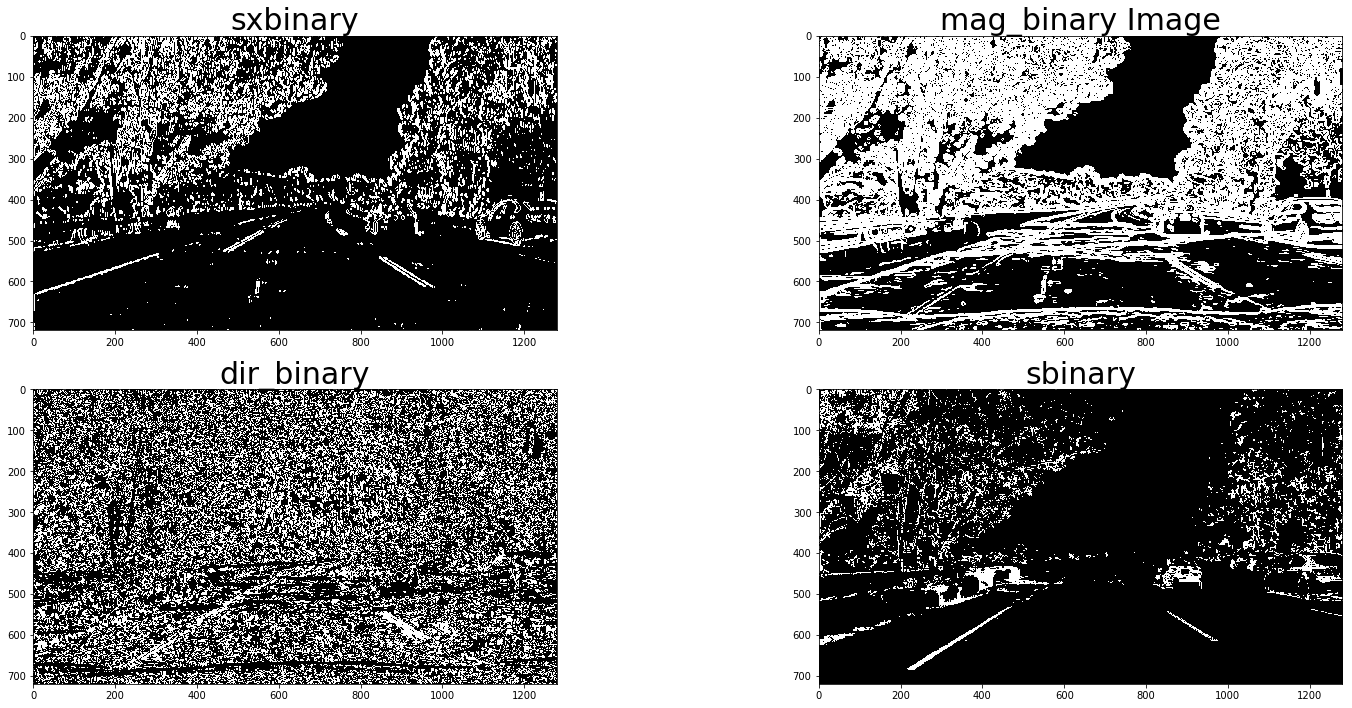

In [84]:
image = mpimg.imread('test_images/test5.jpg')
img = np.copy(image)

ksize = 15
sxbinary = abs_sobel_thresh(img, 'x', ksize, (20, 100))
mag_binary = mag_thresh(img, ksize, (10, 200))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(40*np.pi/180., 74.5*np.pi/180.))
sbinary = s_channel_thres(img, ksize, (170, 255))
l_binary = l_channel_thres(img, ksize, thresh=(100, 255))


f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(sxbinary, cmap="gray")
ax1.set_title('sxbinary', fontsize=30)
ax2.imshow(mag_binary, cmap="gray")
ax2.set_title('mag_binary Image', fontsize=30)
ax3.imshow(dir_binary, cmap="gray")
ax3.set_title('dir_binary', fontsize=30)
ax4.imshow(sbinary, cmap="gray")
ax4.set_title('sbinary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

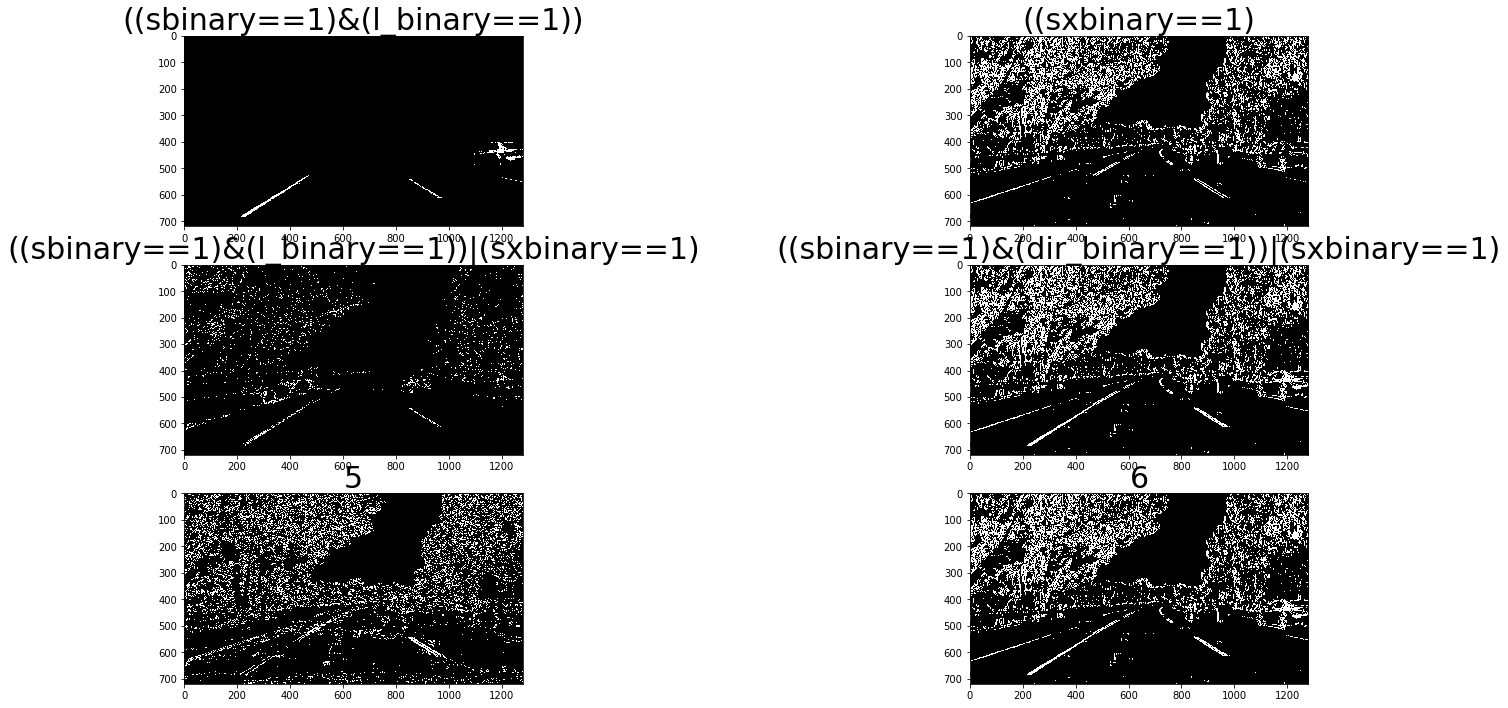

In [90]:
img1='output_images/straight_lines2_undist.jpg'
img2='test_images/test5.jpg'
image = mpimg.imread(img2)
img = np.copy(image)

ksize = 9
sxbinary = abs_sobel_thresh(img, 'x', ksize, (20, 100))
mag_binary = mag_thresh(img, ksize, (10, 100))
sbinary = s_channel_thres(img, ksize, (170, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(40*np.pi/180., 74.5*np.pi/180.))
l_binary = l_channel_thres(img, ksize, thresh=(100, 255))


combined1 = np.zeros_like(dir_binary)
combined1[((sbinary==1)&(l_binary==1))] = 1

combined2 = np.zeros_like(dir_binary)
combined2[(sxbinary==1)] = 1

combined3 = np.zeros_like(dir_binary)
combined3[(sbinary==1)&(dir_binary==1)] = 1

combined4 = np.zeros_like(dir_binary)
combined4[(combined1==1)|(sxbinary==1)] = 1

combined5 = np.zeros_like(dir_binary)
combined5[(mag_binary==1)&(dir_binary==1)] = 1

combined6 = np.zeros_like(dir_binary)
combined6[(sxbinary==1)|(combined3==1)|(combined5==1)] = 1

combined6 = combined_thres(img)

f, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, figsize=(20,10))
ax1.imshow(combined1, cmap="gray")
ax1.set_title('((sbinary==1)&(l_binary==1))', fontsize=30)
ax2.imshow(combined2, cmap="gray")
ax2.set_title('((sxbinary==1)', fontsize=30)
ax3.imshow(combined3, cmap="gray")
ax3.set_title('((sbinary==1)&(l_binary==1))|(sxbinary==1)', fontsize=30)
ax4.imshow(combined4, cmap="gray")
ax4.set_title('((sbinary==1)&(dir_binary==1))|(sxbinary==1)', fontsize=30)
ax5.imshow(combined5, cmap="gray")
ax5.set_title('5', fontsize=30)
ax6.imshow(combined6, cmap="gray")
ax6.set_title('6', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


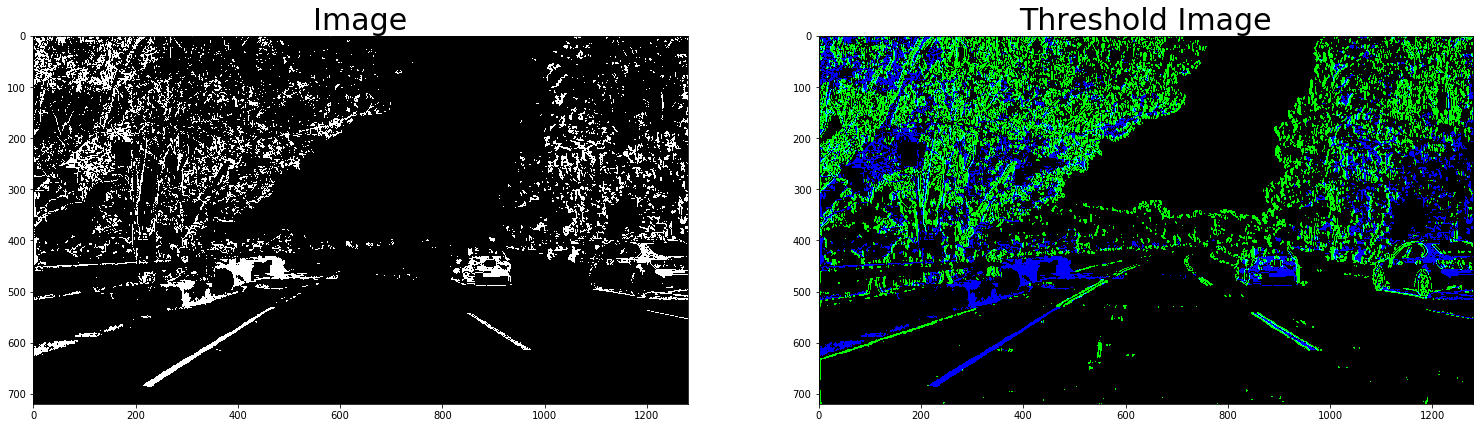

In [42]:
image = mpimg.imread('test_images/test5.jpg')
img = np.copy(image)

sxbinary = abs_sobel_thresh(img, 'x', 9, (20, 100))
sbinary = s_channel_thres(img, 9, (170, 255))

color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, sbinary)) * 255
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sbinary, cmap="gray")
ax1.set_title('Image', fontsize=30)
ax2.imshow(color_binary, cmap="gray")
ax2.set_title('Threshold Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Play ground II

- Find approximate perspective transform source points.
- Test perspective transform 

Text(0.5,1,'Undistorted and warped Image')

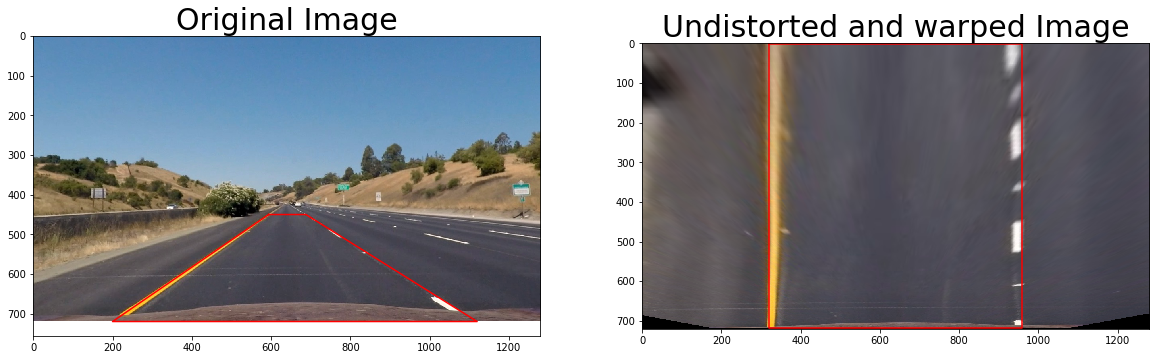

In [13]:
import matplotlib
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import cv2

%matplotlib inline

# assume road is flat plane, use a undist striaght line image. 
straight_lines2_undist_img = plt.imread('output_images/straight_lines1_undist.jpg')
straight_lines2_undist_img = cv2.cvtColor(straight_lines2_undist_img, cv2.COLOR_BGR2RGB)
img_sz = (straight_lines2_undist_img.shape[1], straight_lines2_undist_img.shape[0])


PT_SRC = np.float32([[594,450], [688,450],[1120, 720], [200, 720]])
PT_DST = np.float32([[320, 2], [img_sz[0] - 320, 2], [img_sz[0] - 320, img_sz[1] - 2], [320, img_sz[1] - 2]])

M = cv2.getPerspectiveTransform(PT_SRC, PT_DST)
Minv = cv2.getPerspectiveTransform(PT_DST, PT_SRC)
warped = cv2.warpPerspective(straight_lines2_undist_img, M, img_sz, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(straight_lines2_undist_img)
ax1.plot(np.append(PT_SRC[:,0],594), np.append(PT_SRC[:,1], 450),color='red')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.plot(np.append(PT_DST[:,0], 320),np.append(PT_DST[:,1], 2), color='red')
ax2.set_title('Undistorted and warped Image', fontsize=30)


Text(0.5,1,'Undistorted and warped Image')

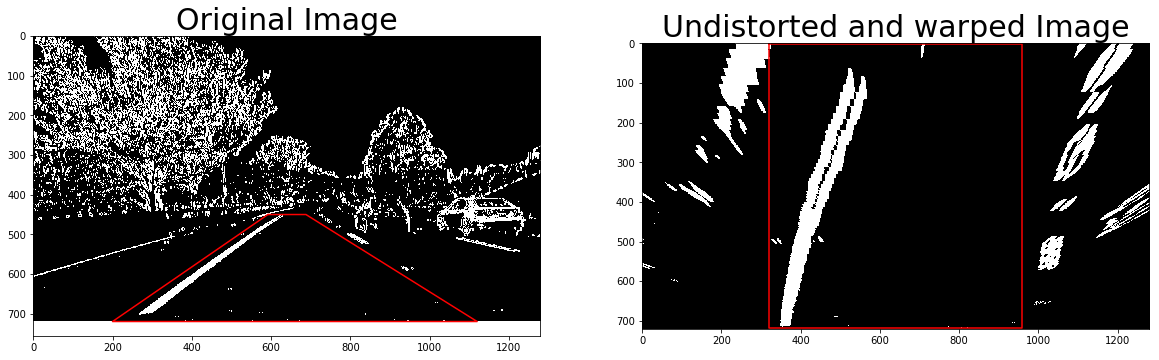

In [59]:
with open('dist_coefficient.p', mode='rb') as f:
    dist_coefficient = pickle.load(f)

mtx = dist_coefficient["mtx"] 
dist = dist_coefficient["dist"]

image = plt.imread("test_images/test6.jpg")
undist = cv2.undistort(image, mtx, dist, None, mtx)

thres_img = combined_thres(undist) 
thres_warped_img = cv2.warpPerspective(thres_img, M, img_sz, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(thres_img,cmap='gray')
ax1.plot(np.append(PT_SRC[:,0],592), np.append(PT_SRC[:,1], 450),color='red')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(thres_warped_img,cmap='gray')
ax2.plot(np.append(PT_DST[:,0], 320),np.append(PT_DST[:,1], 2), color='red')
ax2.set_title('Undistorted and warped Image', fontsize=30)

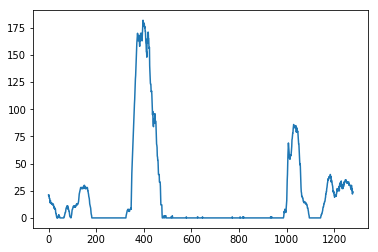

In [60]:
import numpy as np
histogram = np.sum(thres_warped_img[thres_warped_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [61]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Take a histogram of the bottom half of the image
histogram = np.sum(thres_warped_img[thres_warped_img.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((thres_warped_img, thres_warped_img, thres_warped_img))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(thres_warped_img.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = thres_warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = thres_warped_img.shape[0] - (window+1)*window_height
    win_y_high = thres_warped_img.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

3715.8752843511297 2897.9265203909204


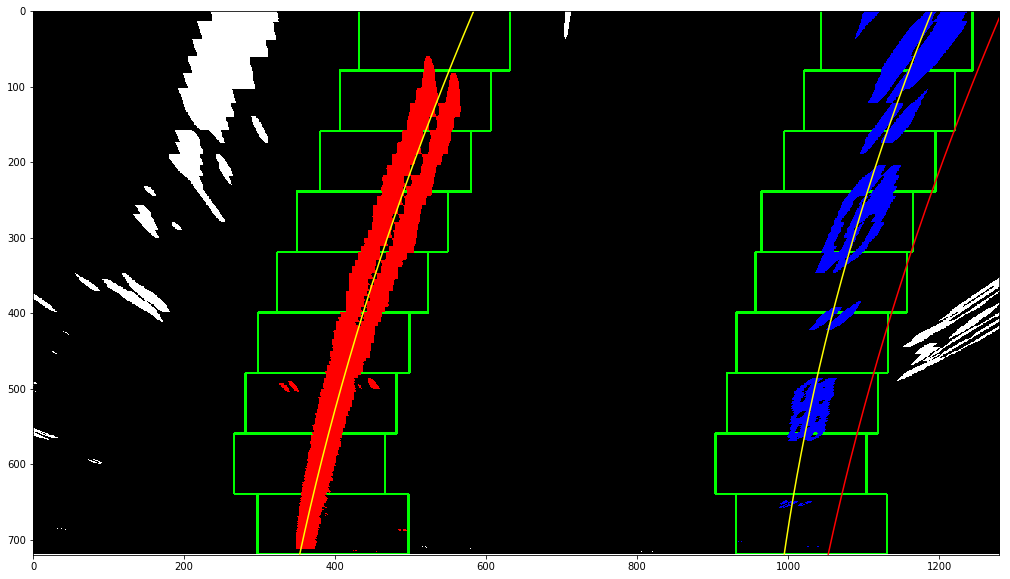

In [62]:
# Generate x and y values for plotting
ploty = np.linspace(0, thres_warped_img.shape[0]-1, thres_warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
f = plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(left_fitx+700, ploty, color='red')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

- test: Determine the curvature of the lane and vehicle position with respect to center.

In [63]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

y_eval = np.max(ploty)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
print('radius of curvature: ', (left_curverad+right_curverad)/2, 'm')

position =  (thres_warped_img.shape[1]/2 - (left_fitx[-1] + right_fitx[-1])/2) * xm_per_pix
print('vehicle position with respect to center: ', position, 'm')


1140.6560182383444 m 923.3954728427544 m
radius of curvature:  1032.0257455405495 m
vehicle position with respect to center:  -0.18023765969473715 m


- Project the lane back down onto the image

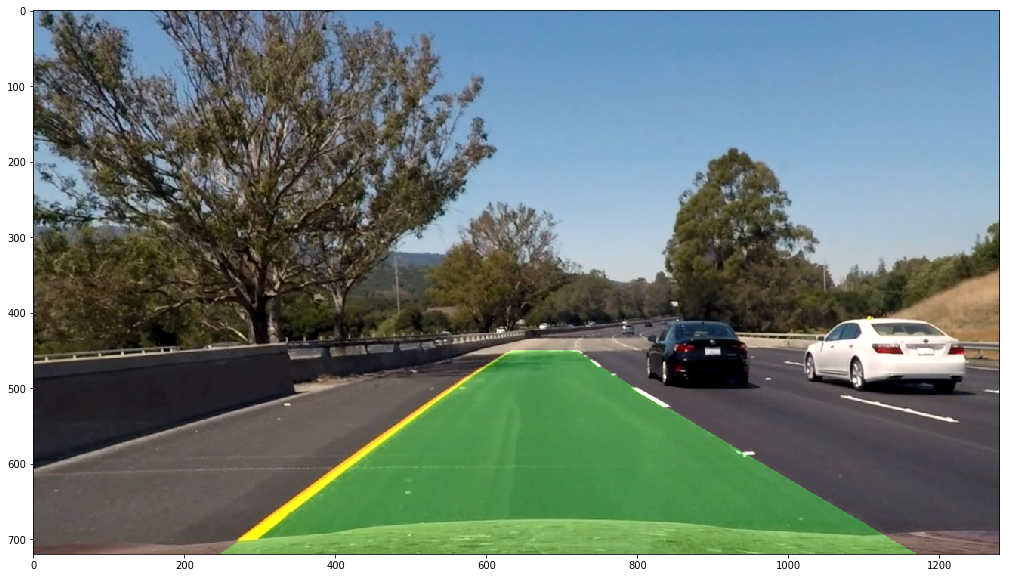

In [64]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(thres_warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
f = plt.figure(figsize=(20,10))
plt.imshow(result)